# Hyperparameter Optimization Using Hyperotp

We will require the following modules for tuning our hyperparams.

In [1]:
# Numpy and Matplot for visualizing our minimum
import numpy as np
import matplotlib.pyplot as plt

# All the components that you will need to optimize our loss function
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import rand, tpe
from hyperopt import Trials
from hyperopt import fmin

### Our Objective function
This is the function that we are trying to optimize here. Think of it as the loss (error) in your model, you want to minimize it as much as you can. In our case our function is a polynomial.

In [2]:
def objective_function(x):
    """Objective function to minimize, for example 
    we have a polynomial 2(x^4)-2(x^3)-200(x^2)-5(x)-200"""
    
    ## Optimization Function
    # simple polynomial function
    f = np.poly1d([2,-2,-200,-5,-200])

    # returning a scaled value for the polynomial for certain value of x
    return f(x) * 0.05

### Visualize our values
This is purely to view the minimum value and where for which value it occurs.
For the given polynomial and values the minimum is about -300 occurring near 7.5.

Minimum of -300.1871 occurs at 7.4617


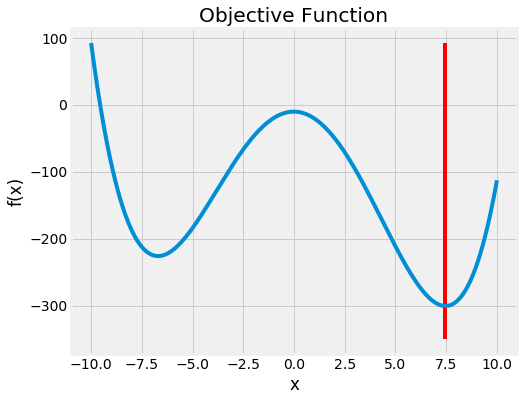

In [3]:
# This part is to visualize the minimum
x = np.linspace(-10, 10, 10000)
y = objective_function(x)

# get the min value of y and corresponding x value
miny = min(y)
minx = x[np.argmin(y)]

# Visualize the function
plt.figure(figsize = (8, 6))
plt.style.use('fivethirtyeight')
plt.title('Objective Function')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.vlines(minx, min(y)- 50, max(y), linestyles = '-', colors = 'r')
plt.plot(x, y)

# Print out the minimum of the function and value
print('Minimum of %0.4f occurs at %0.4f' % (miny, minx))

### Domain Space
These are the values we were earlier talking about, for our case the domain space are values occurring between -10 and 10.

[]

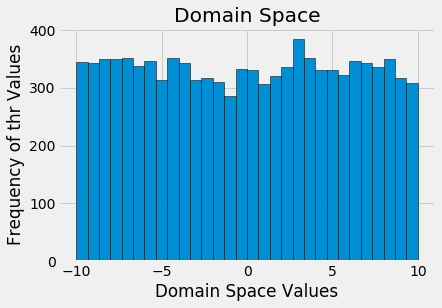

In [84]:
## Domain Space
space = hp.uniform('x', -10, 10)

samples = []

# Sample 10000 random values from the range, this is not need for the algorithm we just do this to visualize it.
for _ in range(10000):
    samples.append(sample(space))
    

# Histogram of the values
plt.hist(samples, bins = 30, edgecolor = 'black')
plt.xlabel('Domain Space Values')
plt.ylabel('Frequency of thr Values')
plt.title('Domain Space')
plt.plot()

I have decided to pit TPE (Tree Structure Parzen) and Random against each other to see which is a better algorithm to find the minimum loss.

In [5]:
# Create objects for the algorithms
tpe_algo = tpe.suggest # Tree Structure Parzen Estimator
rand_algo = rand.suggest # Random Forest

# Create two trials objects to record your estimations
tpe_trials = Trials()
rand_trials = Trials()

### Running The Algorithms
We run the algorithm using a objective function, domain space and our choice of algorithm.

In [6]:
# Run 2000 trials with the tpe algorithm with our objective function and domain space
tpe_best = fmin(fn=objective_function, space=space, algo=tpe_algo, trials=tpe_trials, 
                max_evals=2000, rstate= np.random.RandomState(50))

# Run 2000 trials with the random algorithm
rand_best = fmin(fn=objective_function, space=space, algo=rand_algo, trials=rand_trials, 
                 max_evals=2000, rstate= np.random.RandomState(50))

100%|██████████| 2000/2000 [00:02<00:00, 480.86it/s, best loss: -300.1867639030902] 


### Results
So if we see the results closely you can see that TPE took fewer trials to find the minimum but each trial took longer, if accuracy is what you are looking for 

In [7]:
# Printing info on the trials
print('Minimum for TPE:        {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum for random:     {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Actual minimum of f(x): {:.4f}'.format(miny))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:    {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random: {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of x from TPE:    {:.4f}'.format(tpe_best['x']))
print('Best value of x from random: {:.4f}'.format(rand_best['x']))
print('Actual best value of x:      {:.4f}'.format(minx))

Minimum for TPE:        -300.1871
Minimum for random:     -300.1868
Actual minimum of f(x): -300.1871

Number of trials needed to attain minimum with TPE:    1464
Number of trials needed to attain minimum with random: 1612

Best value of x from TPE:    7.4621
Best value of x from random: 7.4579
Actual best value of x:      7.4617


### This is a practical example of hyperopt for KNN
Here I have **randomized the dataset** and the value of **k** and we use hyperopt to find the optimal value for **k**.
We import sklearn and pandas for our model processing.

In [11]:
import io
import requests
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt

I have used a dataset from my earlier assignment and I have split the dataset into the traditional 20-80 split for testing and training respectively. *Requires internet*

In [14]:
url="https://raw.githubusercontent.com/S-Mann/hyperparameter_optimization/master/dataset/dataset.csv"
s=requests.get(url).content
dataset=pd.read_csv(io.StringIO(s.decode('utf-8')))

# We exclude the target and derived columns
excluded_columns = [x not in ['model','msrp','cost_per_unit','profit_per_unit'] for x in dataset.columns]

X = dataset.iloc[:,excluded_columns].values
y = dataset.iloc[:,dataset.columns == 'msrp'].values

We do a bit of data cleansing with the imputer to remove NaN values in the X_train and X_test (target variables), we need to scale our values as they are quite different in sizes.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

# Create our imputer to replace missing values with the mean e.g.
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(X_train)
X_train = imp.transform(X_train)
imp = imp.fit(X_test)
X_test = imp.transform(X_test)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

For fmin() to work you need to convert your model into a function, hence I am defining my function here.

In [25]:
def knn_obj_func(n):    
    classifier = KNeighborsClassifier(n_neighbors=int(n))
    classifier.fit(X_train, np.ravel(y_train, order='C'))
    y_pred = classifier.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    return rmse

Here we specify a **random** value for **k**.

In [61]:
random_hyperparam = 7
random_loss = knn_obj_func(7)
random_loss

16098.013942788846

Now that we have our objective function we can define our domain space and for us the values of k can be anything from 2 to as high as possible but we will go with 500 as max.

In [29]:
space = hp.uniform('x', 2, 500)
samples = []

for _ in range(100):
    samples.append(sample(space))    

We create our trails and initialize our algorithms

In [32]:
# Create objects for the algorithms
tpe_algo = tpe.suggest # Tree Structure Parzen Estimator
rand_algo = rand.suggest # Random Forest

# Create two trials objects to record your estimations
tpe_trials = Trials()
rand_trials = Trials()

This is where the real magic happens we feed our **objective function** and **domain space** to **fmin()** which will find the minimum loss.

In [33]:
# Run 2000 trials with the tpe algorithm with our objective function and domain space
tpe_best = fmin(fn=knn_obj_func, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=100, rstate= np.random.RandomState(50))

# Run 2000 trials with the random algorithm with our objective function and domain space
rand_best = fmin(fn=knn_obj_func, space=space, algo=rand_algo, trials=rand_trials, max_evals=100, rstate= np.random.RandomState(50))

100%|██████████| 100/100 [11:05<00:00,  4.50s/it, best loss: 12588.454672948326]


Now we see the results, lesser the loss is better the hyperparam. As we can see that **TPE found the least amount of loss** but you will need to run it for much longer, it literally took **4.46 secs * 76 trials** to get the minimum. But random wasn't far off, it all depends how much loss is acceptable in your model.

Minimum loss for TPE:        11055.0884
Minimum loss for random:     12588.4547
Default k's loss:            16098.0139

Number of trials needed to attain minimum with TPE:     76
Number of trials needed to attain minimum with random:  4

Best value of k from TPE:    2
Best value of k from random: 6
Default value of k:          7


[]

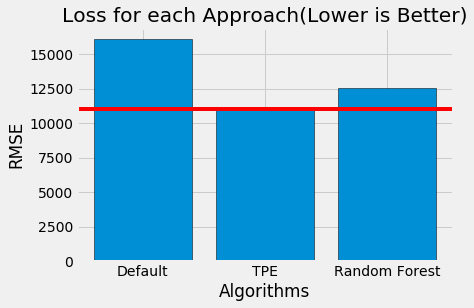

In [83]:
# Printing info on the trials
print('Minimum loss for TPE:        {:.4f}'.format(tpe_trials.best_trial['result']['loss']))
print('Minimum loss for random:     {:.4f}'.format(rand_trials.best_trial['result']['loss']))
print('Default k\'s loss:            {:.4f}'.format(random_loss))

# Print out information about number of trials
print('\nNumber of trials needed to attain minimum with TPE:     {}'.format(tpe_trials.best_trial['misc']['idxs']['x'][0]))
print('Number of trials needed to attain minimum with random:  {}'.format(rand_trials.best_trial['misc']['idxs']['x'][0]))

# Print out information about value of x
print('\nBest value of k from TPE:    {:.0f}'.format(tpe_best['x']))
print('Best value of k from random: {:.0f}'.format(rand_best['x']))
print('Default value of k:          {:.0f}'.format(random_hyperparam))

plt.bar(['Default','TPE','Random Forest'], 
        [random_loss, tpe_trials.best_trial['result']['loss'], rand_trials.best_trial['result']['loss']], 
        edgecolor='black')
plt.xlabel('Algorithms')
plt.ylabel('RMSE')
plt.title('Loss for each Approach(Lower is Better)')
plt.axhline(y=tpe_trials.best_trial['result']['loss'], color = 'r')
plt.plot()